<a href="https://colab.research.google.com/github/YoungjaeDev/HuggingFace-Tutorial/blob/master/Transformers_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMDB Pytorch 버전으로 재학습**

In [1]:
!pip install transformers

In [2]:
import transformers
print(transformers.__version__)

4.38.2


In [3]:
!pip install torchtext==0.15.2 portalocker==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install accelerate -U

  Using cached accelerate-0.29.2-py3-none-any.whl (297 kB)


In [2]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

In [3]:
import random
random.seed(6)

# train_iter를 리스트 타입으로 변경
train_lists = list(train_iter)
test_lists = list(test_iter)

# 각기 1000개씩 랜덤 샘플링
train_lists_small = random.sample(train_lists, 1000)
test_lists_small = random.sample(test_lists, 1000)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [7]:
def test_inference(model, tokenizer):
    input_tokens = tokenizer(["I feel fantastic", "My life is going something wrong", "I have not figured out what the chosen title has to do with the movie."], truncation=True, padding=True)
    outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

    label_dict = {1:'positive', 0:'negative'}

    return [label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()]

In [8]:
print(test_inference(model, tokenizer))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


['negative', 'negative', 'negative']


In [9]:
train_texts = []
train_labels = []

# for 반복문
# train_lists_small에 담긴 튜플 쌍 원소를 변수명 label과 text를 부여하여 순서대로 추출
for label, text in train_lists_small:
  # IMDB 데이터의 기존 레이블 2를 1로 변경, 기존 레이블 1을 0으로 변경
  train_labels.append(1 if label == 2 else 0)
  train_texts.append(text)

# text_texts와 test_labels라는 컨테이너 생성
test_texts = []
test_labels = []

# for 반복문
for label, text in test_lists_small:
  # IMDB 데이터의 기존 레이블 2를 1로 변경, 기존 레이블 1을 0으로 변경
  test_labels.append(1 if label == 2 else 0)
  test_texts.append(text)

# 각 변수에 담긴 인덱스 0에 해당하는 원소, 즉 첫번째 원소 출력
print(train_texts[0])
print(train_labels[0])
print(test_texts[0])
print(test_labels[0])

I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.
1
This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Truly a horri

In [10]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [11]:
# Dataset 클래스를 상속하는 IMDBDataset 클래스를 정의
class IMDbDataset(Dataset):

    # 생성자 __init__()
    # 자신을 가르키는 매개변수 self 포함
    # 변수를 저장하기 위해 self.변수명을 사용
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # 자신을 가르키는 매개변수 self 포함
    def __getitem__(self, idx):
        # self.encoding에 담긴 키(key)와 키값(value)을 items()로 추출
        # 이 값을 key와 val 변수에 담아 새로운 키(key)와 키값(torch.tensor(val[idx]))를 갖는 딕셔너리 생성
        # 딕셔너리는 {"key1:value1", "key2:value2", ,,,} 형태를 지닌 파이썬 데이터 구조
        # val[idx]에 담긴 데이터를 torch.tensor()를 통해 파이토치 텐서로 변환
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # self.lables[idx]에 담긴 데이터를 torch.tensor()를 통해 파이토치 텐서 변환
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # 자신을 가르키는 매개변수 self 포함
    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

model.train()

losses = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
for epoch in range(8):
  print(f'epoch: {epoch}')

  for batch in train_loader:
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss = outputs[0]
    losses.append(loss)

    loss.backward()

    optim.step()


model.eval()

print(test_inference(model, tokenizer))

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
['positive', 'negative', 'positive']


In [14]:
print(losses)
print(type(losses))

# item 함수를 사용하면 텐서 값을 파이썬 숫자로 추출하여 CPU로 전달

new_losses = [i.item() for i in losses]
print(new_losses[:5], new_losses[-5:])

[tensor(0.6867, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6678, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7151, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6410, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6711, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.8142, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7522, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6654, device='

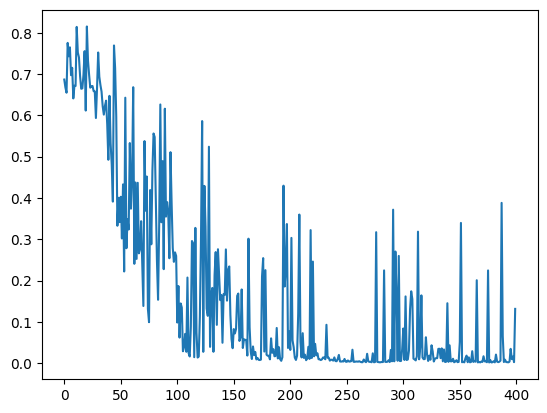

In [15]:
import matplotlib.pyplot as plt

plt.plot(new_losses)
plt.show()

## **테스트셋에 대한 정확도 추출**

In [18]:
model.eval()

test_predictions = []

for test_text in test_texts:
  input_tokens = tokenizer([test_text], truncation=True, padding=True)

  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

  test_predictions.append( torch.argmax(outputs['logits'], axis=1).item() )

In [19]:
test_predictions[:5]

[0, 0, 0, 0, 1]

In [23]:
correct_cnt = 0

for pred, gt in zip(test_predictions, test_labels):
  if pred == gt:
    correct_cnt += 1

print(correct_cnt/len(test_labels) * 100, '%')

86.2 %


In [24]:
from sklearn.metrics import classification_report

# label이 1인 부분을 확인하면 됨
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       521
           1       0.87      0.84      0.85       479

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

